In [2]:
import matplotlib.pyplot as plt
import numpy as np

My initial attempt to keep track of phase note-to-note are not so great. The code for this is directly below. This "works" but has problems when the sines are of different amplitude. 

However, I had some issues, so I will try some approaches from this DSP Stack Exchange I asked.
https://dsp.stackexchange.com/questions/83009

## Implementation, as described here: 
https://dsp.stackexchange.com/a/83058/62456

> ### Use phase from the start, and do not just multiply by time t - this is vital 
For each sine wave, use a variable to hold the current phase. 
Then for each time step, multiply 2 * np.pi * freq by the time step interval and add that incremental change to the previous phase value. 
You'll also need to check for the sum exceeding 2*np.pi and subtract 2*np.pi when it does. With this solution, you're guaranteed a stepless frequency change.
>
> There's an even more important benefit from this too, which is essential to know for real-world DSP. 
As time t becomes larger, the value will start to run out of floating-point precision for the time step interval. 
Your sine wave will become progressively less accurate as the program runs, until at some point the value loses precision entirely and the sine wave will simply stop moving. 
The lower the frequency and the shorter the sample rate, the sooner this'll happen; but maths says it will always happen eventually. 
This is a very common bug for novice DSP implementations, and it's often not obvious because everything may seem to work fine until you've had your code running for a few hours and then it mysteriously just freezes.
>
> Incremental phase changes do have a similar issue of course, where the increment may be too small to represent with your floating-point precision. 
Using double-precision floating-point is usually the way to go here. 
The advantage you have with this though is that if there is a precision problem, you're guaranteed to see it within one sine-wave period, so it won't come as some kind of surprise.
>
> ### Ramp amplitudes if they can change
>
> Your code has a fixed amplitude of 1 for both sine waves. (By the way, if the amplitude is 1 then you don't need to multiply by it.) If you want changes to amplitude to be stepless, one solution is to ramp the amplitude from the previous value to the new value. You can choose a suitable ramp period for your application.
> 
> ### And/or change settings at zero crossing
> The other simple strategy for amplitude changes is to hold off changing until the next zero-crossing of the sine wave. Multiplying anything by zero results in zero, so you're guaranteed that this will be stepless. This works well for fast sine waves. For slow sine waves where the sine wave period may be longer than a reasonable ramp transition, it might not be the best strategy though.
>
>Changing settings at the zero crossing can also work for frequencies too, but there's generally less reason to need that. Still though, if you want the frequency and magnitude to both change in step with each other, you can change them both when the phase crosses 2*np.pi, and you're good. By the way, don't expect the phase to ever exactly hit 2*np.pi, so a zero-crossing transition is never going to be perfectly stepless, but it's still likely to be better than most other strategies.

OH WAIT 
I can use the zero-crossing suggestion, which is what I previously was attempting (from my understanding). 

I would be able to treat each row of an array independently, which should address the concern I had with chords / timbre-rich content. I was intially thinking I had to quantize **every** note in a chord, for example, to the a common denominator, but that's not the case. As I said, each row can be independent. 

| chord 1 | chord 2 | chord 3 | 
|---------|---------|---------|
| a       | d       | e       |
| c#      | f#      | g#      |
| e       | a       | b       |

In the above example, the row `a - d - e` would be treated as one, with each note being quantized to its last zero-crossing value (or cycle that's closest to the requested duration [will need to compare my previous approach with zero-crossing]). Same goes for `c# - f# - g#` and `e - a - b`. 

Each note in every *column* may have slightly different lengths, but this will be imperceptible to the user. 

In [ ]:
from synthesizing import Tone

In [4]:
sample_rate = 22050
freq1 = np.random.randint(50, 300)
freq2 = np.random.randint(200, 600)

print(f'{freq1=}, {freq2=}')

T = Tone(freq1, 0.125, sample_rate, amplitude=0.25).tone
T2 = Tone(freq2, 0.125, sample_rate, amplitude=0.2).tone


freq1=230, freq2=500


NameError: name 'Tone' is not defined

In [ ]:
plt.figure(figsize=(22,14), dpi=150)
plt.plot(T)
plt.plot(T2)
plt.legend([f'{freq1}hz', f'{freq2}hz'])

next:
create last_tone_length kinda variable to keep track of each tones' length 

In [38]:
def get_duration_in_samples(frequency, duration, sample_rate):
    if frequency == 0:
        return 0

    cycle_time_samples = sample_rate / frequency
    num_samples = sample_rate * duration
    range_cycles = np.ceil(np.arange(0, int(num_samples + cycle_time_samples), cycle_time_samples))

    diff_second_to_last, diff_last = abs(num_samples - range_cycles[-2]), abs(num_samples - range_cycles[-1])

    which_cycle = np.argmin([diff_second_to_last, diff_last])

    return range_cycles[-2] if which_cycle == 0 else range_cycles[-1]

In [1]:
timbre = ((1, 0.5), (2, 0.2), (5, 0.2))
refrain = np.matrix(
    [
        [220, 200.2, 100],
        [  0, 300.2,   0],
        [  0, 600.3,   0],
        [  0,     0,   0]
    ]
) 

durations = [0.5, 0.5, 0.5]
sample_rate = 22050 

vectorized_get_dur_in_samples = np.vectorize(get_duration_in_samples)

refrain_samples = vectorized_get_dur_in_samples(refrain, durations, sample_rate)
refrain_samples

NameError: name 'np' is not defined

I should probably reconsider the input of this because - right now - I'm the only one using it. I can put in a matrix as a `refrain` and that's fine. I shouldn't overcomplicate things.

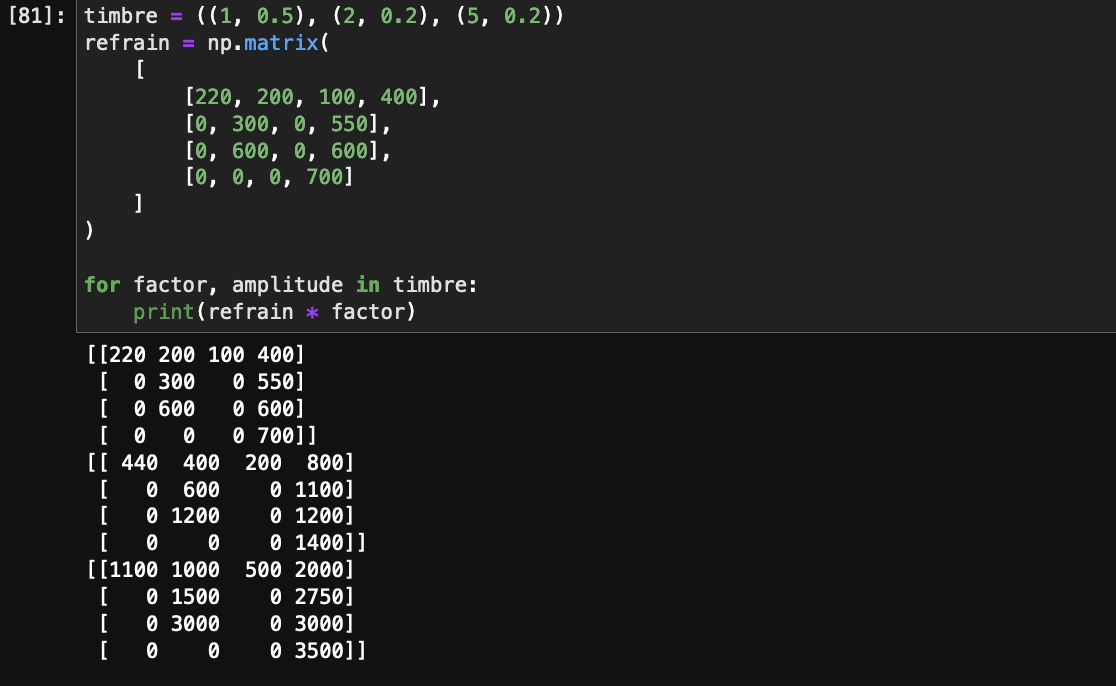